# Neurodynamics - Homework 02: Leaky-Integrate-and-Fire Model

Group: Katarzyna Olszynska (1000023) & Benjamin Peters (982981)

## Imports

In [ ]:
!pip install brian2

In [ ]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

## Question 1

Implement the following simple leaky-integrate-and-fire model in *brian2*:

$\frac{dV}{dt} = - \frac{1}{\tau_{M}}((V-V_{R})+\frac{I}{g_{L}}) \\
t_{spike} : V(t_{spike}) > V_{t} \ \ \& \ \ V \to V_{R}$

Set $\tau_{M}= 20ms$, $V_{R} = -70mV$ and $g_{L}= 0.1\mu S$.

When the membrane potential hits the threshold $V_{t} = -50 mV$, emit a spike and reset the membrane potential to resting. In **brian2**, thresholds and resets are part of a **NeuronGroup** definition. You can also attach a **SpikeMonitor** to the model neuron to easily collect all spike times.

In [ ]:
def simulate_lif(time_span, input_current):
  """
  This function describes the simulation of neural spiking behaviour according to a leaky-integrate-and-fire model.

  Parameters:
  time_span -- denotes the length of the simulation
  input_current -- an input of type TimedArray() containing the input currents

  Returns:
  spikemon.num_spikes -- the number of emitted spikes as collected by the SpikeMonitor
  """
  start_scope()

  # model parameters
  tau_M = 20.0*ms
  v_R = -70*mV
  v_T = -50*mV
  g_L = 0.1*usiemens
  I = input_current

  # define the differential equations for the LIF model
  eqs = """
  dv/dt = 1/tau_M * (-(v-v_R) + I/g_L) : volt
  """

  # describe conditions for spiking threshold, reset, and refractory period
  threshold = "v > v_T"
  reset = "v = v_R"
  refrac = 3*ms

  # create a NeuronGroup with respective spiking threshold and reset
  neuron = NeuronGroup(1, model=eqs, threshold=threshold, reset=reset, refractory=refrac, method="exponential_euler")
  neuron.v = v_R

  # set up the SpikeMonitor to collect firing times and frequencies
  spikemon = SpikeMonitor(neuron)

  # create a Network object to manage the simulation
  net = Network(neuron, spikemon)
  # run a simulation for given duration
  net.run(time_span)

  return spikemon.num_spikes

Your task is to set up multiple experiments with 50 varying currents *I* from 0.0 to 20.0 nA. For each value, record how many spikes the neuron fires in one second.

In [ ]:
# run the experiment for one second
duration = 1000*ms

# initialize array for input currents
currents = np.linspace(0, 20, 50)
input_currents = currents * nA

# run the experiment for 50 varying currents from 0 to 20 nA
spike_counts = [simulate_lif(duration, current) for current in input_currents]

Plot the f-I curve, frequency against current, to characterize the neuron's input-output function.

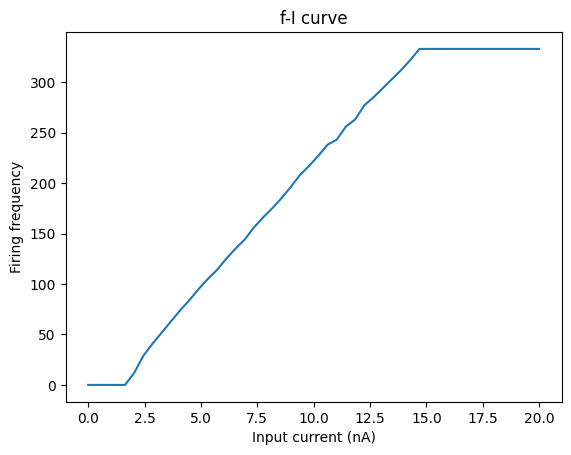

In [ ]:
fig, ax = plt.subplots()

ax.plot(currents, spike_counts)
ax.set(title="f-I curve", xlabel="Input current (nA)", ylabel="Firing frequency")

plt.show()

We can see that the LIF neuron will not fire until a certain input current (ca. $2nA$), after which we observe a linear increase until a threshold of possible spikes is reached. The latter is determined by the duration of the experiment as well as the refractory period (here: $3ms$), resulting in a maximum of 333 spikes for the given experiment.

## Question 2

Amend the model and include synaptic transmission.

In ***brian2***, modelling synaptic conductance in response to spikes is easier as a dynamic variable. The equations for the integrate-and-fire model extend to:

$\frac{dV}{dt} = - \frac{1}{\tau_{M}}((V-V_{R})+\frac{g_{S}}{g_{L}}(V-E_{S})) \\
\frac{dg_{s}}{dt} = - \frac{g_{S}}{\tau_{S}} \\
t_{spike} : V(t_{spike}) > V_{t} \ \ \& \ \ V \to V_{R}$

Set $\tau_{S}= 5.0ms$ and $E_{S} = 10mV$. $g_{L}$ changes to 3$\mu S$ ($\to 3mS \ ? $).

Additionally, use **PoissonGroup** to create 10 input neurons, and then use the **brian2.Synapse** to connect them to the neuron. On each spike, add 0.6 mS to the synaptic conductance $g_{s}$ (use the option **on_pre += 0.6mS**).

In [ ]:
def simulate_synaptic_lif(input_rate, time_span):
  """
  This function describes the simulation of neural spiking behaviour according to a leaky-integrate-and-fire model.
  This time, we also include a synaptic transmission.

  Parameters:
  input_rate -- the firing frequency in Hertz that the PoissonGroup input neurons fire at
  time_span -- denotes the length of the simulation

  Returns:
  spikemon.num_spikes -- the number of emitted spikes as collected by the SpikeMonitor
  """
  start_scope()

  # model parameters
  tau_M = 20*ms
  tau_S = 5*ms
  v_R = -70*mV
  v_T = -50*mV
  g_L = 3*msiemens
  E_S = 10*mV

  # define the differential equations for the LIF model
  eqs = """
  dv/dt = -1/tau_M * ((v-v_R) + (g_S/g_L) * (v-E_S)) : volt
  dg_S/dt = (-1/tau_S) * g_S : siemens
  """

  # describe conditions for spiking threshold, reset, and refractory period
  threshold = "v > v_T"
  reset = "v = v_R"
  refrac = 3*ms

  # create a NeuronGroup with respective spiking threshold and reset
  neuron = NeuronGroup(1, model=eqs, threshold=threshold, reset=reset, method="exponential_euler")
  neuron.v = v_R
  neuron.g_S = 0*msiemens

  # create input neurons
  input_neurons = PoissonGroup(10, np.arange(10) * Hz + input_rate)
  # create a synaptic connection between input and target neurons
  synapses = Synapses(input_neurons, neuron, on_pre="g_S += 0.6*msiemens")
  synapses.connect()

  # set up the SpikeMonitor to collect firing times and frequencies
  spikemon = SpikeMonitor(neuron)

  # create a Network object to manage the simulation
  net = Network(neuron, spikemon, input_neurons, synapses)
  # run a simulation for given duration
  net.run(time_span)

  return spikemon.num_spikes

Now, set up the previous experiment -- but instead of varying the current *I*, vary the firing frequency in Hertz that the **PoissonGroup** input neurons fire at from 0 to 200 Hz in 20 steps. Record and plot the firing frequency the neuron responds with.

In [ ]:
# initialize array for input currents
freqs = np.linspace(0, 200, 20)
input_freqs = freqs * Hz

# run the experiment for 20 varying firing frequencies from 0 to 200 Hz
spike_counts_2 = [simulate_synaptic_lif(freq, duration) for freq in input_freqs]

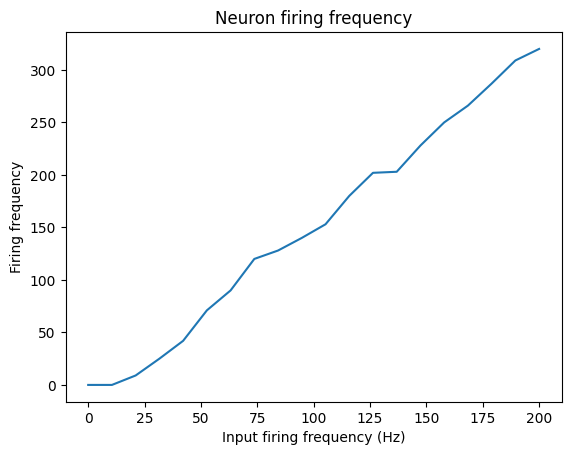

In [ ]:
# plot the results
fig, ax = plt.subplots()

ax.plot(freqs, spike_counts_2)
ax.set(title="Neuron firing frequency", xlabel="Input firing frequency (Hz)", ylabel="Firing frequency")

plt.show()